<a href="https://colab.research.google.com/github/llukitas/Interbank_Kaggle/blob/master/Recomendacion_ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Instalacion de utilitarios Pyspark

#  **03/11/2019**

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz


In [0]:
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


In [5]:
!pip install pyspark

     |████████████████████████████████| 215.7MB 56kB/s 
     |████████████████████████████████| 204kB 40.3MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=016d0afb04558a953eec8c153bf43cac719e18d5d35531ed83bf8a8c84571f11
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

# 1. Lectura del origen datos

In [0]:
# Lectura desde un archivo fisico
from google.colab import files
uploaded = files.upload()

In [7]:

# Conexion al drive
#---------------------------
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
ls

drive/        spark-2.3.4-bin-hadoop2.7/     spark-2.4.4-bin-hadoop2.7/
sample_data/  spark-2.3.4-bin-hadoop2.7.tgz  spark-2.4.4-bin-hadoop2.7.tgz


#2.  Cargando los datos en formato Spark

In [9]:
DS_peliculas_rating = spark.read.csv('/content/drive/My Drive/AGRARIA_ML/Training R ML en Casos de Negocios/8_Recomendacion_comercio/Comercio_tipo_rappi.csv', sep=';', header=True, inferSchema=True)

# 2.1 Revision de formatos 
DS_peliculas_rating.printSchema()

root
 |-- userID: string (nullable = true)
 |-- userID_cod: integer (nullable = true)
 |-- placeID: integer (nullable = true)
 |-- Nombre_comerce: string (nullable = true)
 |-- Distrito: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- food_rating: integer (nullable = true)
 |-- service_rating: integer (nullable = true)
 |-- rating_total: integer (nullable = true)



In [10]:
# Dimensiona de base
print((DS_peliculas_rating.count(),len(DS_peliculas_rating.columns)))

(50766, 9)


In [11]:
# 2.2 Revisiones  
DS_peliculas_rating.show(5)

+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+
|userID|userID_cod|placeID|      Nombre_comerce|       Distrito|rating|food_rating|service_rating|rating_total|
+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+
| U1077|         1| 135085|Tortas Locas Hipo...|San Luis Potosi|     2|          2|             2|           6|
| U1077|         1| 135038|Restaurant la Cha...|San Luis Potosi|     2|          2|             1|           5|
| U1077|         1| 132825|     puesto de tacos|         s.l.p.|     2|          2|             2|           6|
| U1077|         1| 135060|Restaurante Maris...|San Luis Potosi|     1|          2|             2|           5|
| U1068|         2| 135104|                vips|              0|     1|          1|             2|           4|
+------+----------+-------+--------------------+---------------+------+-----------+--------------+------

In [12]:
# 2.3 Validacion de carga del total de registros
print(DS_peliculas_rating.count())

50766


In [13]:
# 2.4 Exploracion inicial
DS_peliculas_rating.describe().show()

+-------+------+------------------+------------------+--------------------+---------+------------------+------------------+------------------+-----------------+
|summary|userID|        userID_cod|           placeID|      Nombre_comerce| Distrito|            rating|       food_rating|    service_rating|     rating_total|
+-------+------+------------------+------------------+--------------------+---------+------------------+------------------+------------------+-----------------+
|  count| 50766|             50766|             50766|               50766|    50766|             50766|             50766|             50766|            50766|
|   mean|  null| 67.34026710790687|  134254.559390143|                null|      0.0|1.2218216916834101| 1.244277666154513| 1.109856990899421|3.575956348737344|
| stddev|  null|32.640689951647815|1079.9216692471784|                null|      0.0|0.7706200957794772|0.7863420037824467|0.7915679876580894|2.083855254035862|
|    min| U1001|                 1

In [14]:
DS_peliculas_rating.filter(DS_peliculas_rating['userID']=='U1106').show()

+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+
|userID|userID_cod|placeID|      Nombre_comerce|       Distrito|rating|food_rating|service_rating|rating_total|
+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+
| U1106|        44| 135041|           Luna Cafe|San Luis Potosi|     1|          1|             1|           3|
| U1106|        44| 135032|Cafeteria y Resta...|San Luis Potosi|     0|          0|             0|           0|
| U1106|        44| 135028|         La Virreina|San Luis Potosi|     2|          1|             0|           3|
| U1106|        44| 135047|Restaurante Casa ...|San Luis Potosi|     0|          0|             0|           0|
| U1106|        44| 135052|La Cantina Restau...|San Luis Potosi|     0|          0|             0|           0|
| U1106|        44| 135106|El Rinc�n de San ...|San Luis Potosi|     0|          0|             0|      

In [15]:
# 2.5 Los clientes que más vistaron la plataforma de videos
DS_peliculas_rating.groupBy('userId').count().orderBy('count',ascending=False).show(10,False)

+------+-----+
|userId|count|
+------+-----+
|U1106 |1198 |
|U1071 |949  |
|U1024 |933  |
|U1016 |897  |
|U1036 |876  |
|U1104 |868  |
|U1009 |759  |
|U1037 |755  |
|U1084 |730  |
|U1132 |730  |
+------+-----+
only showing top 10 rows



In [16]:
# 2.6  Las clientes que menos vieron las peliculas
DS_peliculas_rating.groupBy('Nombre_comerce').count().orderBy('count',ascending=True).show(10,False)

+-------------------------------------+-----+
|Nombre_comerce                       |count|
+-------------------------------------+-----+
|emilianos                            |99   |
|Carnitas Mata  Calle 16 de Septiembre|100  |
|cafe ambar                           |100  |
|la perica hamburguesa                |102  |
|tortas hawai                         |109  |
|puesto de gorditas                   |109  |
|tacos los volcanes                   |118  |
|churchs                              |126  |
|TACOS EL GUERO                       |133  |
|Arrachela Grill                      |135  |
+-------------------------------------+-----+
only showing top 10 rows



In [17]:
DS_peliculas_rating.groupBy('Distrito').count().orderBy('count',ascending=False).show(10,False)

+---------------+-----+
|Distrito       |count|
+---------------+-----+
|San Luis Potosi|33108|
|0              |4283 |
|Cuernavaca     |3824 |
|san luis potosi|1969 |
|victoria       |1642 |
|s.l.p.         |1387 |
|Jiutepec       |1001 |
|Soledad        |705  |
|Ciudad Victoria|629  |
|s.l.p          |497  |
+---------------+-----+
only showing top 10 rows



In [18]:
DS_peliculas_rating.groupBy('rating_total').count().orderBy('count',ascending=False).show(10,False)

+------------+-----+
|rating_total|count|
+------------+-----+
|6           |13423|
|3           |9707 |
|0           |8115 |
|4           |7757 |
|5           |6324 |
|2           |3790 |
|1           |1650 |
+------------+-----+



In [19]:
#Cliente que mas consume en determinado comercio
DS_peliculas_rating.filter(DS_peliculas_rating['Nombre_comerce']=='Luna Cafe').groupBy('userID').count().orderBy('count',ascending=False).show()

+------+-----+
|userID|count|
+------+-----+
| U1024|   73|
| U1049|   73|
| U1005|   73|
| U1104|   69|
| U1045|   69|
| U1054|   61|
| U1075|   49|
| U1126|   41|
| U1106|   41|
| U1086|   40|
| U1061|   40|
| U1101|   38|
| U1135|   38|
| U1003|   38|
| U1078|   38|
| U1088|   35|
| U1002|   20|
+------+-----+



In [20]:
# 2.6  Las clientes que menos vieron las peliculas
DS_peliculas_rating.groupBy('Distrito').count().orderBy('count',ascending=True).show(10,False)

+----------------+-----+
|Distrito        |count|
+----------------+-----+
|san luis potos  |99   |
|Cd. Victoria    |100  |
|Cd Victoria     |216  |
|victoria        |252  |
|san luis potosi |268  |
|slp             |319  |
|cuernavaca      |467  |
|s.l.p           |497  |
|Ciudad Victoria |629  |
|Soledad         |705  |
+----------------+-----+
only showing top 10 rows



In [21]:
# 2.7  Las peliculas con mayor numero de visualizaciones
DS_peliculas_rating.groupBy('Nombre_comerce').count().orderBy('count',ascending=False).show(10,False)

+----------------------------------+-----+
|Nombre_comerce                    |count|
+----------------------------------+-----+
|Tortas Locas Hipocampo            |1641 |
|Cafeteria y Restaurant El Pacifico|1466 |
|puesto de tacos                   |1387 |
|La Cantina Restaurante            |1202 |
|Restaurant la Chalita             |1200 |
|Gorditas Doa Gloria               |1176 |
|Restaurante Marisco Sam           |1017 |
|Restaurant Oriental Express       |955  |
|Restaurante El Cielo Potosino     |945  |
|Luna Cafe                         |836  |
+----------------------------------+-----+
only showing top 10 rows



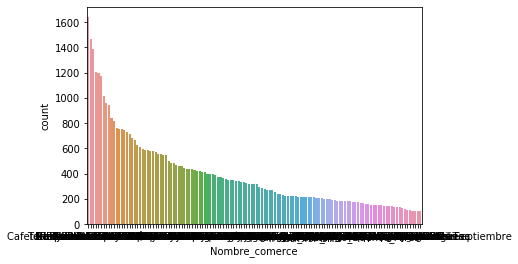

In [22]:
#Graficas
res= DS_peliculas_rating.groupBy('Nombre_comerce').count().orderBy('count',ascending=False)
red=res.toPandas()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ax=sns.barplot(x="Nombre_comerce", y="count", data=red)



In [24]:
# Peliculas con menos numero de visualizaciones 
DS_peliculas_rating.groupBy('Nombre_comerce').count().orderBy('count',ascending=True).show(10,False)

+-------------------------------------+-----+
|Nombre_comerce                       |count|
+-------------------------------------+-----+
|emilianos                            |99   |
|Carnitas Mata  Calle 16 de Septiembre|100  |
|cafe ambar                           |100  |
|la perica hamburguesa                |102  |
|tortas hawai                         |109  |
|puesto de gorditas                   |109  |
|tacos los volcanes                   |118  |
|churchs                              |126  |
|TACOS EL GUERO                       |133  |
|Arrachela Grill                      |135  |
+-------------------------------------+-----+
only showing top 10 rows



In [0]:
# El cliente 100 y el 450 cold celd
DS_peliculas_rating.filter((DS_peliculas_rating['Nombre_comerce']=='Star Wars (1977)')&(DS_peliculas_rating['userId']=='450')).show()
#DS_peliculas_rating.filter((DS_peliculas_rating['title']=='Star Wars (1977)')&(DS_peliculas_rating['userId']=='100')).show()

# 3. FEature Engineering: Tansforma pelicula a numero



In [0]:
# Importando el codifocador
from pyspark.ml.feature import StringIndexer,IndexToString

In [0]:
# Configurando la Numerzación los titulos de las peliculas
# title_new = La codificación de las peliculas
stringIndexer = StringIndexer(inputCol="Nombre_comerce", outputCol="Nombre_comerce_new")

In [0]:
#Aplicando la numerización de peliculas
model = stringIndexer.fit(DS_peliculas_rating)

In [0]:
#Creando un nuevo Dataframe con el indexado creado
indexed = model.transform(DS_peliculas_rating)

In [29]:
#Revision de los indices
indexed.show(10)

+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+------------------+
|userID|userID_cod|placeID|      Nombre_comerce|       Distrito|rating|food_rating|service_rating|rating_total|Nombre_comerce_new|
+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+------------------+
| U1077|         1| 135085|Tortas Locas Hipo...|San Luis Potosi|     2|          2|             2|           6|               0.0|
| U1077|         1| 135038|Restaurant la Cha...|San Luis Potosi|     2|          2|             1|           5|               4.0|
| U1077|         1| 132825|     puesto de tacos|         s.l.p.|     2|          2|             2|           6|               2.0|
| U1077|         1| 135060|Restaurante Maris...|San Luis Potosi|     1|          2|             2|           5|               6.0|
| U1068|         2| 135104|                vips|              0|     1|          1|

In [30]:
#Numero de veces que cada titulo ha aparecido
indexed.groupBy('Nombre_comerce_new').count().orderBy('count',ascending=False).show(10,False)

+------------------+-----+
|Nombre_comerce_new|count|
+------------------+-----+
|0.0               |1641 |
|1.0               |1466 |
|2.0               |1387 |
|3.0               |1202 |
|4.0               |1200 |
|5.0               |1176 |
|6.0               |1017 |
|7.0               |955  |
|8.0               |945  |
|9.0               |836  |
+------------------+-----+
only showing top 10 rows



# 4. Dividiendo la data en muestra de entrenamiento y validacion


In [0]:
#4.1  Data de entrenamiento y validacion
train,test=indexed.randomSplit([0.75,0.25],seed=1234)

In [32]:
# Nro de entrenamiento
train.count()

38060

In [33]:
# Nro de Validacion
test.count()

12706

# 5. Entrenando el Modelo


In [0]:
#Importando el modelo Recomendador ALS
from pyspark.sql.functions import *
from pyspark.ml.recommendation import ALS


In [0]:
#Configuracion del Entrenamiento del modelo Recomendador usando la muetsra de entrenamiento
rec=ALS(maxIter=10,regParam=0.01,userCol='userID_cod',itemCol='Nombre_comerce_new',ratingCol='rating_total',nonnegative=True,coldStartStrategy="drop",implicitPrefs=False,seed=1234)

# maxIter: El maximo de iteraciones
# regParam: Parametro de REgularización
# nonnegative: Especificar si se utiliza una restriccion negativa en los Minimos cuadrados
# coldStartStrategy: Parametro que elimina cualquier cliente que no tenga informacion
# implicitPrefs: Si es implicito hace referencia a feedback no registrado voluntariamente por el cliente

In [0]:
#Entrenando el modelo
rec_model=rec.fit(train)

In [0]:
#Haciendo las predicciones en la data de test 
predicted_ratings=rec_model.transform(test)

In [38]:
#Revisando los pronostico
predicted_ratings.printSchema()

root
 |-- userID: string (nullable = true)
 |-- userID_cod: integer (nullable = true)
 |-- placeID: integer (nullable = true)
 |-- Nombre_comerce: string (nullable = true)
 |-- Distrito: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- food_rating: integer (nullable = true)
 |-- service_rating: integer (nullable = true)
 |-- rating_total: integer (nullable = true)
 |-- Nombre_comerce_new: double (nullable = false)
 |-- prediction: float (nullable = false)



In [39]:
# Revision rapida de los pronosticos
predicted_ratings.orderBy(rand()).show(10)

+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+------------------+----------+
|userID|userID_cod|placeID|      Nombre_comerce|       Distrito|rating|food_rating|service_rating|rating_total|Nombre_comerce_new|prediction|
+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+------------------+----------+
| U1028|       130| 132733|       Little Cesarz|Ciudad Victoria|     1|          1|             1|           3|              51.0|  3.051311|
| U1015|        12| 132869|       Dominos Pizza|San Luis Potosi|     2|          2|             2|           6|              59.0| 5.9421577|
| U1042|        88| 135021|              Subway|     Cuernavaca|     1|          2|             0|           3|              38.0| 3.0008461|
| U1005|        60| 135057|El Herradero Rest...|San Luis Potosi|     1|          2|             1|           4|              13.0| 4.1161346|
| U104

In [0]:
# Generando los top 10 peliculas sugeridas por cada cliente
userRecs = rec_model.recommendForAllUsers(10)

In [41]:
userRecs.show(5,False)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userID_cod|recommendations                                                                                                                                                           |
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|31        |[[54, 6.0120754], [101, 5.4295473], [94, 5.0036316], [119, 4.995816], [40, 4.9185524], [58, 4.719034], [34, 4.550688], [65, 4.4456825], [62, 4.40077], [26, 4.2081914]]   |
|85        |[[77, 5.998091], [86, 4.4816856], [65, 3.9762225], [116, 3.9088037], [74, 3.8237128], [79, 3.7655823], [34, 3.5224311], [19, 3.4967995], [99, 3.4836204], [121, 3.398422]]|
|137       |[[6, 6.655279], [51, 6.305241], [61, 5.772696], [59, 5.768441], [11,

# 5. Evaluación del poder predictivo del modelo


In [42]:
# Creando la columna diferencia del pronostico
predicted_ratings_witherr=predicted_ratings.withColumn('err',abs(predicted_ratings.prediction - predicted_ratings.rating))

predicted_ratings_witherr.show()

+------+----------+-------+---------------+--------+------+-----------+--------------+------------+------------------+----------+---------+
|userID|userID_cod|placeID| Nombre_comerce|Distrito|rating|food_rating|service_rating|rating_total|Nombre_comerce_new|prediction|      err|
+------+----------+-------+---------------+--------+------+-----------+--------------+------------+------------------+----------+---------+
| U1062|        93| 132872|Pizzeria Julios|   s.l.p|     0|          0|             0|           0|              31.0|       0.0|      0.0|
| U1062|        93| 132872|Pizzeria Julios|   s.l.p|     0|          0|             0|           0|              31.0|       0.0|      0.0|
| U1062|        93| 132872|Pizzeria Julios|   s.l.p|     0|          0|             0|           0|              31.0|       0.0|      0.0|
| U1062|        93| 132872|Pizzeria Julios|   s.l.p|     0|          0|             0|           0|              31.0|       0.0|      0.0|
| U1062|        93| 

In [43]:
# Distribución de las valoraciones
predicted_ratings.groupBy('rating_total').count().orderBy('rating_total',ascending=True).show()

+------------+-----+
|rating_total|count|
+------------+-----+
|           0| 2055|
|           1|  404|
|           2|  925|
|           3| 2485|
|           4| 1883|
|           5| 1567|
|           6| 3387|
+------------+-----+



In [44]:
# Error promedio por rating de valoracion
predicted_ratings_witherr.groupBy('rating_total').agg({'err':'mean'}).orderBy('rating_total',ascending=True).show()

+------------+-------------------+
|rating_total|           avg(err)|
+------------+-------------------+
|           0|0.13259095880180288|
|           1| 0.7532827600394145|
|           2|  1.327604872987077|
|           3| 1.9705980539801615|
|           4|  2.636680823466402|
|           5| 3.2443232347650293|
|           6| 3.9561610273953063|
+------------+-------------------+



In [45]:
# Error promedio por rating de valoracion
predicted_ratings_witherr.groupBy('rating_total').agg({'err':'std'}).orderBy('rating_total',ascending=True).show()

+------------+-------------------+
|rating_total|        stddev(err)|
+------------+-------------------+
|           0|0.20719662257838592|
|           1| 0.4560509912437527|
|           2| 0.5126864701762673|
|           3|0.33457197978731307|
|           4| 0.5583086609947838|
|           5|0.46281714498219173|
|           6|0.12290088069475512|
+------------+-------------------+



In [0]:
#Importando el evaluador de Regresion RMSE 
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
#Evluando la presición del pronostico
evaluator=RegressionEvaluator(metricName='rmse',predictionCol='prediction',labelCol='rating_total')

In [0]:
#Evluando el error de pronostico global
rmse=evaluator.evaluate(predicted_ratings)

In [49]:
#Imprimiento el error
print(rmse)

0.15906528216358914


# 6. Recomendandor de peliculas, ya listo!

In [0]:
#Listado de comercios unicas
unique_movies=indexed.select('Nombre_comerce_new').distinct()

In [51]:
#Total de peliculas
unique_movies.count()

129

In [52]:
unique_movies.show(10,False)

+------------------+
|Nombre_comerce_new|
+------------------+
|67.0              |
|8.0               |
|70.0              |
|0.0               |
|69.0              |
|7.0               |
|112.0             |
|124.0             |
|128.0             |
|108.0             |
+------------------+
only showing top 10 rows



In [0]:
#Asignando un alias {a} la lista unica de peliculas
a = unique_movies.alias('a')

In [55]:
a.show(5)

+------------------+
|Nombre_comerce_new|
+------------------+
|              67.0|
|               8.0|
|              70.0|
|               0.0|
|              69.0|
+------------------+
only showing top 5 rows



In [73]:
# Eligiendo un cliente
user_id=44

# Creando una tabla que contiene una pelicula por usuario
watched_movies=indexed.filter(indexed['userID_cod'] == user_id).select('Nombre_comerce_new').distinct()

#Numero de peliculas ya evaluadas 
watched_movies.count()

18

In [0]:
# Asignando un alias  {b} ha peliculas que el usuario ya vio de la tabla
b=watched_movies.alias('b')

In [75]:
b.show()

+------------------+
|Nombre_comerce_new|
+------------------+
|               8.0|
|               0.0|
|               7.0|
|              18.0|
|               1.0|
|              45.0|
|              14.0|
|              22.0|
|               3.0|
|              19.0|
|              27.0|
|              10.0|
|              20.0|
|              32.0|
|               5.0|
|              24.0|
|               9.0|
|              16.0|
+------------------+



In [0]:
#Cruzando ambas tablas
total_movies = a.join(b, a.Nombre_comerce_new == b.Nombre_comerce_new,how='left')

In [77]:
total_movies.show(10,False)

+------------------+------------------+
|Nombre_comerce_new|Nombre_comerce_new|
+------------------+------------------+
|67.0              |null              |
|8.0               |8.0               |
|70.0              |null              |
|0.0               |0.0               |
|69.0              |null              |
|7.0               |7.0               |
|112.0             |null              |
|124.0             |null              |
|128.0             |null              |
|108.0             |null              |
+------------------+------------------+
only showing top 10 rows



In [0]:
# Seleccionando peliculas que el cliente aun no ha mirado
remaining_movies=total_movies.where(col("b.Nombre_comerce_new").isNull()).select(a.Nombre_comerce_new).distinct()

In [79]:
remaining_movies.show(4)

+------------------+
|Nombre_comerce_new|
+------------------+
|              67.0|
|              70.0|
|              69.0|
|             112.0|
+------------------+
only showing top 4 rows



In [80]:
# Numero de peliculas que los usuario aun no lo ven 
remaining_movies.count()

111

In [0]:
# Agregando una nueva columna del usuario 
remaining_movies=remaining_movies.withColumn("userID_cod",lit(int(user_id)))

In [82]:
remaining_movies.show(10,False)

+------------------+----------+
|Nombre_comerce_new|userID_cod|
+------------------+----------+
|67.0              |44        |
|70.0              |44        |
|69.0              |44        |
|112.0             |44        |
|124.0             |44        |
|128.0             |44        |
|108.0             |44        |
|88.0              |44        |
|49.0              |44        |
|101.0             |44        |
+------------------+----------+
only showing top 10 rows



In [0]:
#Configuracion del Entrenamiento del modelo Recomendador usando la muetsra de entrenamiento
rec=ALS(maxIter=10,regParam=0.01,userCol='userID_cod',itemCol='Nombre_comerce_new',ratingCol='rating_total',nonnegative=True,coldStartStrategy="drop",implicitPrefs=False,seed=1234)


In [0]:
rec_model=rec.fit(train)

In [0]:
# Haciendo la recomendacion de peliculas utilizando el modelo recomendador ALS y seleccionado solo las mejores top {n} peliculas
recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False)

In [84]:
recommendations.show(5,False)

+------------------+----------+----------+
|Nombre_comerce_new|userID_cod|prediction|
+------------------+----------+----------+
|40.0              |44        |9.987749  |
|96.0              |44        |9.136231  |
|82.0              |44        |8.960599  |
|105.0             |44        |8.761664  |
|43.0              |44        |7.6725235 |
+------------------+----------+----------+
only showing top 5 rows



In [0]:
# Consiguiendo los de las peliculas sugeridas
movie_title = IndexToString(inputCol="Nombre_comerce_new", outputCol="title",labels=model.labels)

final_recommendations=movie_title.transform(recommendations)

In [86]:
final_recommendations.show(10,False)

+------------------+----------+----------+-------------------------------------+
|Nombre_comerce_new|userID_cod|prediction|title                                |
+------------------+----------+----------+-------------------------------------+
|40.0              |44        |9.987749  |Restaurant Las Mananitas             |
|96.0              |44        |9.136231  |El Oceano Dorado                     |
|82.0              |44        |8.960599  |Hamburguesas La perica               |
|105.0             |44        |8.761664  |carnitas mata calle Emilio Portes Gil|
|43.0              |44        |7.6725235 |la Cantina                           |
|29.0              |44        |6.9119864 |Gordas de morales                    |
|92.0              |44        |6.7846313 |La Estrella de Dimas                 |
|68.0              |44        |6.6497407 |shi ro ie                            |
|61.0              |44        |6.5408883 |Gorditas Dona Tota                   |
|83.0              |44      

# 7. Construyendo las funcion que sugiera una pelicula recomendada segun el modelo recomendador

In [0]:
# Funcion para recomendar las top n peliculas para cualquier usuario
#Configuracion del Entrenamiento del modelo Recomendador usando la muetsra de entrenamiento
#rec=ALS(maxIter=10,regParam=0.01,userCol='userID_cod',itemCol='Nombre_comerce_new',ratingCol='rating_total',nonnegative=True,coldStartStrategy="drop",implicitPrefs=False,seed=1234)

def top_movies(user_id,n):
    """
    This function returns the top 'n' movies that user has not seen yet but might like 
    
    """
    # Asignación de una lista de peliculas unicas a
    a = unique_movies.alias('a')
    
    # Creando otra tabla que contiene las peliculas que ya vio el usuario
    watched_movies=indexed.filter(indexed['userID_cod'] == user_id).select('Nombre_comerce_new')
    
    # Asignanción de tabla de peliculas b de peliculas ya vistas 
    b=watched_movies.alias('b')
    
    # Cruce de ambas tablas
    total_movies = a.join(b, a.Nombre_comerce_new == b.Nombre_comerce_new,how='left')
    
    # Seleccionando peliculas que el usuario no ha visto aun 
    remaining_movies=total_movies.where(col("b.Nombre_comerce_new").isNull()).select(a.Nombre_comerce_new).distinct()
        
    #Agregando una nueva columan del cliente  
    remaining_movies=remaining_movies.withColumn("userID_cod",lit(int(user_id)))
    
    # REalizando la recomendnado de peliculas mas adecuada utilizando el Sistema de recomendador del modelo ALS y seleccionando las mejores peliculas
    recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False).limit(n)

    # Agregando los titulos de las peliculas en texto   
    movie_title = IndexToString(inputCol="Nombre_comerce_new", outputCol="title",labels=model.labels)
    final_recommendations=movie_title.transform(recommendations)
    
    # Entregando los titutlos recomendado por usuario
    return final_recommendations.show(n,False)


In [88]:
# REvision del clientes y las 10 peliculas sugeridas para el cliente
top_movies(100,10)

+------------------+----------+----------+-------------------------------------+
|Nombre_comerce_new|userID_cod|prediction|title                                |
+------------------+----------+----------+-------------------------------------+
|105.0             |100       |11.122177 |carnitas mata calle Emilio Portes Gil|
|82.0              |100       |9.549035  |Hamburguesas La perica               |
|61.0              |100       |8.776969  |Gorditas Dona Tota                   |
|29.0              |100       |8.728466  |Gordas de morales                    |
|77.0              |100       |8.685676  |Giovannis                            |
|37.0              |100       |8.645403  |Mariscos El Pescador                 |
|11.0              |100       |8.216457  |El Rincon de San Francisco           |
|79.0              |100       |8.163841  |carnitas_mata                        |
|120.0             |100       |7.8885307 |TACOS EL GUERO                       |
|24.0              |100     

In [0]:
# El cliente 450 que revisa Star Wars
DS_peliculas_rating.filter((DS_peliculas_rating['rating']>4)&(DS_peliculas_rating['userId']=='450')).show()

In [89]:
# REvision del clientes y las 10 peliculas sugeridas para el cliente
top_movies(44,15)

+------------------+----------+----------+-------------------------------------+
|Nombre_comerce_new|userID_cod|prediction|title                                |
+------------------+----------+----------+-------------------------------------+
|40.0              |44        |9.987749  |Restaurant Las Mananitas             |
|96.0              |44        |9.136231  |El Oceano Dorado                     |
|82.0              |44        |8.960599  |Hamburguesas La perica               |
|105.0             |44        |8.761664  |carnitas mata calle Emilio Portes Gil|
|43.0              |44        |7.6725235 |la Cantina                           |
|29.0              |44        |6.9119864 |Gordas de morales                    |
|92.0              |44        |6.7846313 |La Estrella de Dimas                 |
|68.0              |44        |6.6497407 |shi ro ie                            |
|61.0              |44        |6.5408883 |Gorditas Dona Tota                   |
|83.0              |44      